### Imports

In [6]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt
import random
import os

In [7]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

### Create Environment

In [8]:
class TradingEnv(gym.Env):
    """
    Long-only Trading Environment.
    Actions:
        0 = Hold
        1 = Buy (go long)
        2 = Sell (close position)
    Observations:
        Flattened window of normalized features + position flag.
    Reward:
        Log-change in portfolio value minus turnover penalty.
    """

    def __init__(
        self,
        df,
        feature_cols=None,
        window_size=50,
        transaction_cost=0.001,
        initial_balance=1.0,
        reward_scaling=1.0,
        deterministic=True,
        turnover_penalty=0.0005
    ):
        super().__init__()
        self.df = df.copy()
        self.feature_cols = feature_cols or [
            "log_return", "SMA_short", "SMA_long", "volatility",
            "open_close_ratio", "high_low_range", "volume_zscore"
        ]
        self.window_size = window_size
        self.transaction_cost = transaction_cost
        self.initial_balance = initial_balance
        self.reward_scaling = reward_scaling
        self.deterministic = deterministic
        self.turnover_penalty = turnover_penalty

        self.start_index = self.window_size
        self.end_index = len(self.df) - 1

        self.action_space = spaces.Discrete(3)
        self.n_features = len(self.feature_cols)
        obs_len = self.window_size * self.n_features + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_len,), dtype=np.float32)

        self.reset()

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.current_step = (
            self.start_index if self.deterministic
            else np.random.randint(self.start_index, self.end_index - 1)
        )

        self.position = 0
        self.cash = self.initial_balance
        self.invested = 0.0
        self.entry_price = 0.0
        self.portfolio_value = self.cash
        self.trades = []

        return self._get_obs(), {}

    def _get_obs(self):
        start = self.current_step - self.window_size + 1
        end = self.current_step + 1
        window = self.df.iloc[start:end][self.feature_cols].values

        mean = window.mean(axis=0)
        std = window.std(axis=0) + 1e-9
        norm_window = (window - mean) / std

        obs = np.concatenate([norm_window.flatten(), np.array([self.position], dtype=np.float32)])
        return obs.astype(np.float32)

    def step(self, action):
        assert self.action_space.contains(action)
        done = False
        info = {}

        prev_portfolio_value = self.portfolio_value
        price_now = float(self.df["Close"].iloc[self.current_step])
        price_next = float(self.df["Close"].iloc[self.current_step + 1])
        prev_position = self.position

        # --- Action Handling ---
        if action == 1 and self.position == 0:  # Buy
            trade_notional = self.cash
            cost = self.transaction_cost * trade_notional
            self.invested = self.cash - cost
            self.entry_price = price_now
            self.position = 1
            self.cash = 0.0
            self.trades.append((self.current_step, 'BUY', price_now, self.portfolio_value))

        elif action == 2 and self.position == 1:  # Sell
            current_value = self.invested * (price_now / self.entry_price)
            trade_notional = current_value
            cost = self.transaction_cost * trade_notional
            self.cash = current_value - cost
            self.invested = 0.0
            self.entry_price = 0.0
            self.position = 0
            self.trades.append((self.current_step, 'SELL', price_now, self.cash))

        # Update portfolio value at next price
        if self.position == 1:
            asset_value_next = self.invested * (price_next / self.entry_price)
            self.portfolio_value = asset_value_next
        else:
            self.portfolio_value = self.cash

        # --- Reward ---
        # log-return of portfolio value (more stable)
        reward = np.log(self.portfolio_value / max(prev_portfolio_value, 1e-9))
        # small penalty for changing position (reduces churn)
        turnover = abs(self.position - prev_position)
        reward -= self.turnover_penalty * turnover
        reward *= self.reward_scaling

        self.current_step += 1
        if self.current_step >= self.end_index:
            done = True

        obs = self._get_obs()
        return obs, float(reward), done, False, info

    def render(self, mode="human"):
        print(f"Step {self.current_step}, Pos {self.position}, "
              f"Cash {self.cash:.4f}, Invested {self.invested:.4f}, "
              f"Portfolio {self.portfolio_value:.4f}")

    def close(self):
        pass


In [9]:
# Load processed dataset
df = pd.read_csv("data.csv", index_col=0, parse_dates=True)
df = df.sort_index()

# Train/Test Split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Feature columns
feature_cols = [
    "log_return", "SMA_short", "SMA_long", "volatility",
    "open_close_ratio", "high_low_range", "volume_zscore"
]

# Environments
env = TradingEnv(train_df, feature_cols=feature_cols, deterministic=False)
test_env = TradingEnv(test_df, feature_cols=feature_cols, deterministic=True)

# Training env with normalization
vec_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(
    vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0
)

# Evaluation env with same normalization wrapper
test_vec_env = DummyVecEnv([lambda: test_env])
test_vec_env = VecNormalize(
    test_vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0
)
test_vec_env.training = False
test_vec_env.norm_reward = False

### Train model

In [10]:
log_dir = "./tb_logs/"
tb_name = "ppo_trading"

model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    verbose=1,
    tensorboard_log=log_dir,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.995,
    ent_coef=0.01,
)

eval_callback = EvalCallback(
    test_vec_env,
    best_model_save_path="./models/",
    log_path="./models/",
    eval_freq=10_000,
    deterministic=True,
    render=False
)

model.learn(
    total_timesteps=800_000,
    tb_log_name=tb_name,
    callback=[eval_callback]
)

Using cuda device
Logging to ./tb_logs/ppo_trading_3


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 762  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 724         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014772753 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -6.54       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0708     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 0.042       |
-----------------------------------------
----------------------------------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=0.20 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.202      |
| time/                   |            |
|    total_timesteps      | 10000      |
| train/                  |            |
|    approx_kl            | 0.01821051 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.02      |
|    explained_variance   | 0.518      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.118     |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.059     |
|    value_loss           | 0.00384    |
----------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 641   |
|    iterations      | 5     |
|    time_elapsed    | 15    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=20000, episode_reward=0.39 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.385       |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.029340735 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.9        |
|    explained_variance   | 0.828       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.115      |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0695     |
|    value_loss           | 0.00206     |
-----------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 611   |
|    iterations      | 10    |
|    time_e

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=30000, episode_reward=0.70 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.696      |
| time/                   |            |
|    total_timesteps      | 30000      |
| train/                  |            |
|    approx_kl            | 0.03436596 |
|    clip_fraction        | 0.307      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.774     |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0827    |
|    n_updates            | 140        |
|    policy_gradient_loss | -0.0663    |
|    value_loss           | 0.00147    |
----------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 596   |
|    iterations      | 15    |
|    time_elapsed    | 51    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=0.44 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.439       |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.044843532 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.668      |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0959     |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0685     |
|    value_loss           | 0.00175     |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 594   |
|    iterations      | 20    |
|    time_elapsed    | 68    |
| 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=50000, episode_reward=0.70 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.7         |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.056273535 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.514      |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0843     |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0597     |
|    value_loss           | 0.00138     |
-----------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 614   |
|    iterations      | 25    |
|    time_e

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=60000, episode_reward=0.82 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.816       |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.063219056 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.474      |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0791     |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0535     |
|    value_loss           | 0.00126     |
-----------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 632   |
|    iterations      | 30    |
|    time_e

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=70000, episode_reward=0.77 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.774       |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.068309955 |
|    clip_fraction        | 0.261       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.417      |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0766     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0491     |
|    value_loss           | 0.00157     |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 642   |
|    iterations      | 35    |
|    time_elapsed    | 111   |
| 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=80000, episode_reward=0.61 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.611      |
| time/                   |            |
|    total_timesteps      | 80000      |
| train/                  |            |
|    approx_kl            | 0.06928057 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.421     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0624    |
|    n_updates            | 390        |
|    policy_gradient_loss | -0.0476    |
|    value_loss           | 0.00142    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 651   |
|    iterations      | 40    |
|    time_elapsed    | 125   |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=90000, episode_reward=0.77 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.772      |
| time/                   |            |
|    total_timesteps      | 90000      |
| train/                  |            |
|    approx_kl            | 0.07358363 |
|    clip_fraction        | 0.291      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.451     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0461    |
|    n_updates            | 430        |
|    policy_gradient_loss | -0.0535    |
|    value_loss           | 0.00127    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 657   |
|    iterations      | 44    |
|    time_elapsed    | 136   |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=0.44 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.444      |
| time/                   |            |
|    total_timesteps      | 100000     |
| train/                  |            |
|    approx_kl            | 0.06354751 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0559    |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0442    |
|    value_loss           | 0.00102    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 664    |
|    iterations      | 49     |
|    time_elapsed    | 151    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=110000, episode_reward=0.21 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.206       |
| time/                   |             |
|    total_timesteps      | 110000      |
| train/                  |             |
|    approx_kl            | 0.076586425 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.38       |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0526     |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.0417     |
|    value_loss           | 0.0012      |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 670    |
|    iterations      | 54     |
|    time_elapsed    | 164  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=120000, episode_reward=0.78 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.783      |
| time/                   |            |
|    total_timesteps      | 120000     |
| train/                  |            |
|    approx_kl            | 0.08997347 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.335     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0726    |
|    n_updates            | 580        |
|    policy_gradient_loss | -0.0412    |
|    value_loss           | 0.00123    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 675    |
|    iterations      | 59     |
|    time_elapsed    | 178    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=130000, episode_reward=0.12 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.118      |
| time/                   |            |
|    total_timesteps      | 130000     |
| train/                  |            |
|    approx_kl            | 0.07449683 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.325     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0446    |
|    n_updates            | 630        |
|    policy_gradient_loss | -0.0424    |
|    value_loss           | 0.0011     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 676    |
|    iterations      | 64     |
|    time_elapsed    | 193    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=140000, episode_reward=0.43 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.432      |
| time/                   |            |
|    total_timesteps      | 140000     |
| train/                  |            |
|    approx_kl            | 0.08230976 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.329     |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0238    |
|    n_updates            | 680        |
|    policy_gradient_loss | -0.0311    |
|    value_loss           | 0.00108    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 667    |
|    iterations      | 69     |
|    time_elapsed    | 211    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=150000, episode_reward=0.43 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.428      |
| time/                   |            |
|    total_timesteps      | 150000     |
| train/                  |            |
|    approx_kl            | 0.07056728 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.314     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0246    |
|    n_updates            | 730        |
|    policy_gradient_loss | -0.039     |
|    value_loss           | 0.000948   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 660    |
|    iterations      | 74     |
|    time_elapsed    | 229    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=160000, episode_reward=0.49 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.489       |
| time/                   |             |
|    total_timesteps      | 160000      |
| train/                  |             |
|    approx_kl            | 0.091863945 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.336      |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0898     |
|    n_updates            | 780         |
|    policy_gradient_loss | -0.0559     |
|    value_loss           | 0.00136     |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 661    |
|    iterations      | 79     |
|    time_elapsed    | 244  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=170000, episode_reward=0.85 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.848       |
| time/                   |             |
|    total_timesteps      | 170000      |
| train/                  |             |
|    approx_kl            | 0.093822844 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.323      |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0848     |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.0522     |
|    value_loss           | 0.00121     |
-----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 666    |
|    iterations      | 84     |
|    t

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=180000, episode_reward=0.97 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.972      |
| time/                   |            |
|    total_timesteps      | 180000     |
| train/                  |            |
|    approx_kl            | 0.09187408 |
|    clip_fraction        | 0.254      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.32      |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0768    |
|    n_updates            | 870        |
|    policy_gradient_loss | -0.051     |
|    value_loss           | 0.00134    |
----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 669    |
|    iterations      | 88     |
|    time_elapsed    | 2

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=190000, episode_reward=1.02 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 1.02        |
| time/                   |             |
|    total_timesteps      | 190000      |
| train/                  |             |
|    approx_kl            | 0.102441356 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0543     |
|    n_updates            | 920         |
|    policy_gradient_loss | -0.043      |
|    value_loss           | 0.000873    |
-----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 672    |
|    iterations      | 93     |
|    t

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=200000, episode_reward=0.92 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.919       |
| time/                   |             |
|    total_timesteps      | 200000      |
| train/                  |             |
|    approx_kl            | 0.082859404 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.32       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0459     |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.0397     |
|    value_loss           | 0.00107     |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 676    |
|    iterations      | 98     |
|    time_elapsed    | 296  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=210000, episode_reward=0.68 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.679      |
| time/                   |            |
|    total_timesteps      | 210000     |
| train/                  |            |
|    approx_kl            | 0.09295187 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0359    |
|    n_updates            | 1020       |
|    policy_gradient_loss | -0.0408    |
|    value_loss           | 0.00112    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 680    |
|    iterations      | 103    |
|    time_elapsed    | 310    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=220000, episode_reward=0.48 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.484      |
| time/                   |            |
|    total_timesteps      | 220000     |
| train/                  |            |
|    approx_kl            | 0.10195403 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.292     |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.102     |
|    n_updates            | 1070       |
|    policy_gradient_loss | -0.0491    |
|    value_loss           | 0.00129    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 680    |
|    iterations      | 108    |
|    time_elapsed    | 325    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=230000, episode_reward=0.46 +/- 0.00
Episode length: 514.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 514       |
|    mean_reward          | 0.461     |
| time/                   |           |
|    total_timesteps      | 230000    |
| train/                  |           |
|    approx_kl            | 0.0910491 |
|    clip_fraction        | 0.216     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.276    |
|    explained_variance   | 0.974     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0592   |
|    n_updates            | 1120      |
|    policy_gradient_loss | -0.0402   |
|    value_loss           | 0.00138   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 677    |
|    iterations      | 113    |
|    time_elapsed    | 341    |
|    total_timesteps | 231424 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=240000, episode_reward=0.38 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.376       |
| time/                   |             |
|    total_timesteps      | 240000      |
| train/                  |             |
|    approx_kl            | 0.066100635 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.245      |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0459     |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.0284     |
|    value_loss           | 0.000927    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 675    |
|    iterations      | 118    |
|    time_elapsed    | 357  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=250000, episode_reward=-0.00 +/- 0.00
Episode length: 514.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 514       |
|    mean_reward          | -0.00444  |
| time/                   |           |
|    total_timesteps      | 250000    |
| train/                  |           |
|    approx_kl            | 0.0920242 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.263    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0533   |
|    n_updates            | 1220      |
|    policy_gradient_loss | -0.033    |
|    value_loss           | 0.000634  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 674    |
|    iterations      | 123    |
|    time_elapsed    | 373    |
|    total_timesteps | 251904 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=260000, episode_reward=0.03 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.0346      |
| time/                   |             |
|    total_timesteps      | 260000      |
| train/                  |             |
|    approx_kl            | 0.083273634 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.28       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0307     |
|    n_updates            | 1260        |
|    policy_gradient_loss | -0.0435     |
|    value_loss           | 0.000398    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 671    |
|    iterations      | 127    |
|    time_elapsed    | 387  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=270000, episode_reward=0.33 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.33       |
| time/                   |            |
|    total_timesteps      | 270000     |
| train/                  |            |
|    approx_kl            | 0.09450837 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.272     |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0371    |
|    n_updates            | 1310       |
|    policy_gradient_loss | -0.0376    |
|    value_loss           | 0.00103    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 670    |
|    iterations      | 132    |
|    time_elapsed    | 403    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=280000, episode_reward=0.38 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.378       |
| time/                   |             |
|    total_timesteps      | 280000      |
| train/                  |             |
|    approx_kl            | 0.112160966 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0661     |
|    n_updates            | 1360        |
|    policy_gradient_loss | -0.0421     |
|    value_loss           | 0.000604    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 668    |
|    iterations      | 137    |
|    time_elapsed    | 419  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=290000, episode_reward=0.05 +/- 0.00
Episode length: 514.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 514       |
|    mean_reward          | 0.0538    |
| time/                   |           |
|    total_timesteps      | 290000    |
| train/                  |           |
|    approx_kl            | 0.1073564 |
|    clip_fraction        | 0.231     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.277    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0725   |
|    n_updates            | 1410      |
|    policy_gradient_loss | -0.0429   |
|    value_loss           | 0.000636  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 667    |
|    iterations      | 142    |
|    time_elapsed    | 435    |
|    total_timesteps | 290816 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=300000, episode_reward=0.31 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.309      |
| time/                   |            |
|    total_timesteps      | 300000     |
| train/                  |            |
|    approx_kl            | 0.08003615 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.255     |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00712    |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0414    |
|    value_loss           | 0.000786   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 666    |
|    iterations      | 147    |
|    time_elapsed    | 451    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=310000, episode_reward=0.54 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.542       |
| time/                   |             |
|    total_timesteps      | 310000      |
| train/                  |             |
|    approx_kl            | 0.111882925 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0775     |
|    n_updates            | 1510        |
|    policy_gradient_loss | -0.0459     |
|    value_loss           | 0.000884    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 664    |
|    iterations      | 152    |
|    time_elapsed    | 468  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=320000, episode_reward=0.15 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.154      |
| time/                   |            |
|    total_timesteps      | 320000     |
| train/                  |            |
|    approx_kl            | 0.11309864 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0485    |
|    n_updates            | 1560       |
|    policy_gradient_loss | -0.039     |
|    value_loss           | 0.00114    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 663    |
|    iterations      | 157    |
|    time_elapsed    | 484    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=330000, episode_reward=0.16 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.161      |
| time/                   |            |
|    total_timesteps      | 330000     |
| train/                  |            |
|    approx_kl            | 0.09084029 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.22      |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0513    |
|    n_updates            | 1610       |
|    policy_gradient_loss | -0.037     |
|    value_loss           | 0.000588   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 663    |
|    iterations      | 162    |
|    time_elapsed    | 500    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=340000, episode_reward=0.28 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.283      |
| time/                   |            |
|    total_timesteps      | 340000     |
| train/                  |            |
|    approx_kl            | 0.08338286 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.234     |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0278    |
|    n_updates            | 1660       |
|    policy_gradient_loss | -0.0282    |
|    value_loss           | 0.000598   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 661    |
|    iterations      | 167    |
|    time_elapsed    | 516    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=350000, episode_reward=0.29 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.292      |
| time/                   |            |
|    total_timesteps      | 350000     |
| train/                  |            |
|    approx_kl            | 0.08824655 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0663    |
|    n_updates            | 1700       |
|    policy_gradient_loss | -0.0267    |
|    value_loss           | 0.000626   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 660    |
|    iterations      | 171    |
|    time_elapsed    | 530    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=360000, episode_reward=0.36 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.357      |
| time/                   |            |
|    total_timesteps      | 360000     |
| train/                  |            |
|    approx_kl            | 0.11762038 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.247     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0324    |
|    n_updates            | 1750       |
|    policy_gradient_loss | -0.036     |
|    value_loss           | 0.000912   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 659    |
|    iterations      | 176    |
|    time_elapsed    | 546    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=370000, episode_reward=0.28 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.276      |
| time/                   |            |
|    total_timesteps      | 370000     |
| train/                  |            |
|    approx_kl            | 0.09085399 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0399    |
|    n_updates            | 1800       |
|    policy_gradient_loss | -0.0358    |
|    value_loss           | 0.000479   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 658    |
|    iterations      | 181    |
|    time_elapsed    | 562    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=380000, episode_reward=0.56 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.562      |
| time/                   |            |
|    total_timesteps      | 380000     |
| train/                  |            |
|    approx_kl            | 0.09300101 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.237     |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0517    |
|    n_updates            | 1850       |
|    policy_gradient_loss | -0.0403    |
|    value_loss           | 0.000812   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 657    |
|    iterations      | 186    |
|    time_elapsed    | 578    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=390000, episode_reward=0.34 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.34       |
| time/                   |            |
|    total_timesteps      | 390000     |
| train/                  |            |
|    approx_kl            | 0.07768084 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.24      |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0588    |
|    n_updates            | 1900       |
|    policy_gradient_loss | -0.0413    |
|    value_loss           | 0.00117    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 657    |
|    iterations      | 191    |
|    time_elapsed    | 595    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=400000, episode_reward=0.42 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.417       |
| time/                   |             |
|    total_timesteps      | 400000      |
| train/                  |             |
|    approx_kl            | 0.084363304 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.237      |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0774     |
|    n_updates            | 1950        |
|    policy_gradient_loss | -0.0415     |
|    value_loss           | 0.000555    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 656    |
|    iterations      | 196    |
|    time_elapsed    | 611  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=410000, episode_reward=0.28 +/- 0.00
Episode length: 514.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 514       |
|    mean_reward          | 0.281     |
| time/                   |           |
|    total_timesteps      | 410000    |
| train/                  |           |
|    approx_kl            | 0.0705556 |
|    clip_fraction        | 0.239     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.283    |
|    explained_variance   | 0.973     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0482   |
|    n_updates            | 2000      |
|    policy_gradient_loss | -0.0302   |
|    value_loss           | 0.000764  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 655    |
|    iterations      | 201    |
|    time_elapsed    | 627    |
|    total_timesteps | 411648 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=420000, episode_reward=0.28 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.281      |
| time/                   |            |
|    total_timesteps      | 420000     |
| train/                  |            |
|    approx_kl            | 0.11188068 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.259     |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0639    |
|    n_updates            | 2050       |
|    policy_gradient_loss | -0.0482    |
|    value_loss           | 0.00108    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 655    |
|    iterations      | 206    |
|    time_elapsed    | 643    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=430000, episode_reward=0.38 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.38       |
| time/                   |            |
|    total_timesteps      | 430000     |
| train/                  |            |
|    approx_kl            | 0.09104915 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0609    |
|    n_updates            | 2090       |
|    policy_gradient_loss | -0.0367    |
|    value_loss           | 0.000897   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 654    |
|    iterations      | 210    |
|    time_elapsed    | 657    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=440000, episode_reward=0.26 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.261      |
| time/                   |            |
|    total_timesteps      | 440000     |
| train/                  |            |
|    approx_kl            | 0.09914887 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0452    |
|    n_updates            | 2140       |
|    policy_gradient_loss | -0.0447    |
|    value_loss           | 0.000984   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 653    |
|    iterations      | 215    |
|    time_elapsed    | 673    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=450000, episode_reward=0.30 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.3        |
| time/                   |            |
|    total_timesteps      | 450000     |
| train/                  |            |
|    approx_kl            | 0.11961919 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0385    |
|    n_updates            | 2190       |
|    policy_gradient_loss | -0.0379    |
|    value_loss           | 0.000621   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 653    |
|    iterations      | 220    |
|    time_elapsed    | 689    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=460000, episode_reward=0.21 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.207       |
| time/                   |             |
|    total_timesteps      | 460000      |
| train/                  |             |
|    approx_kl            | 0.113113254 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0219     |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0414     |
|    value_loss           | 0.000827    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 652    |
|    iterations      | 225    |
|    time_elapsed    | 705  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=470000, episode_reward=0.17 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.169      |
| time/                   |            |
|    total_timesteps      | 470000     |
| train/                  |            |
|    approx_kl            | 0.10050234 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.242     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0559    |
|    n_updates            | 2290       |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 0.000407   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 652    |
|    iterations      | 230    |
|    time_elapsed    | 722    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=480000, episode_reward=0.26 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.258      |
| time/                   |            |
|    total_timesteps      | 480000     |
| train/                  |            |
|    approx_kl            | 0.08456917 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.242     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0139    |
|    n_updates            | 2340       |
|    policy_gradient_loss | -0.0339    |
|    value_loss           | 0.00051    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 651    |
|    iterations      | 235    |
|    time_elapsed    | 738    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=490000, episode_reward=0.40 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.403      |
| time/                   |            |
|    total_timesteps      | 490000     |
| train/                  |            |
|    approx_kl            | 0.07200351 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.225     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0511    |
|    n_updates            | 2390       |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 0.00071    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 651    |
|    iterations      | 240    |
|    time_elapsed    | 754    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500000, episode_reward=0.29 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.289      |
| time/                   |            |
|    total_timesteps      | 500000     |
| train/                  |            |
|    approx_kl            | 0.10589542 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0725    |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.0482    |
|    value_loss           | 0.00159    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 650    |
|    iterations      | 245    |
|    time_elapsed    | 771    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=510000, episode_reward=0.44 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.442      |
| time/                   |            |
|    total_timesteps      | 510000     |
| train/                  |            |
|    approx_kl            | 0.08714415 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.232     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0513    |
|    n_updates            | 2490       |
|    policy_gradient_loss | -0.0297    |
|    value_loss           | 0.000767   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 650    |
|    iterations      | 250    |
|    time_elapsed    | 787    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=520000, episode_reward=0.52 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.524       |
| time/                   |             |
|    total_timesteps      | 520000      |
| train/                  |             |
|    approx_kl            | 0.117404506 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0337     |
|    n_updates            | 2530        |
|    policy_gradient_loss | -0.036      |
|    value_loss           | 0.00106     |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 649    |
|    iterations      | 254    |
|    time_elapsed    | 800  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=530000, episode_reward=0.47 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.468      |
| time/                   |            |
|    total_timesteps      | 530000     |
| train/                  |            |
|    approx_kl            | 0.09299549 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.242     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0706    |
|    n_updates            | 2580       |
|    policy_gradient_loss | -0.0367    |
|    value_loss           | 0.00036    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 649    |
|    iterations      | 259    |
|    time_elapsed    | 816    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=540000, episode_reward=0.57 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.567       |
| time/                   |             |
|    total_timesteps      | 540000      |
| train/                  |             |
|    approx_kl            | 0.090105206 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0414     |
|    n_updates            | 2630        |
|    policy_gradient_loss | -0.04       |
|    value_loss           | 0.000883    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 648    |
|    iterations      | 264    |
|    time_elapsed    | 833  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=550000, episode_reward=1.06 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 1.06       |
| time/                   |            |
|    total_timesteps      | 550000     |
| train/                  |            |
|    approx_kl            | 0.10444188 |
|    clip_fraction        | 0.154      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0868    |
|    n_updates            | 2680       |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 0.000328   |
----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 648    |
|    iterations      | 269    |
|    time_elapsed    | 8

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=560000, episode_reward=0.81 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.813       |
| time/                   |             |
|    total_timesteps      | 560000      |
| train/                  |             |
|    approx_kl            | 0.097111195 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0687     |
|    n_updates            | 2730        |
|    policy_gradient_loss | -0.0429     |
|    value_loss           | 0.000778    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 648    |
|    iterations      | 274    |
|    time_elapsed    | 865  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=570000, episode_reward=0.59 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.586      |
| time/                   |            |
|    total_timesteps      | 570000     |
| train/                  |            |
|    approx_kl            | 0.08812274 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.246     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.064     |
|    n_updates            | 2780       |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 0.000766   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 648    |
|    iterations      | 279    |
|    time_elapsed    | 881    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=580000, episode_reward=0.78 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.778      |
| time/                   |            |
|    total_timesteps      | 580000     |
| train/                  |            |
|    approx_kl            | 0.08824632 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.235     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0357    |
|    n_updates            | 2830       |
|    policy_gradient_loss | -0.0331    |
|    value_loss           | 0.00063    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 647    |
|    iterations      | 284    |
|    time_elapsed    | 898    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=590000, episode_reward=0.72 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.724      |
| time/                   |            |
|    total_timesteps      | 590000     |
| train/                  |            |
|    approx_kl            | 0.08542617 |
|    clip_fraction        | 0.207      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0416    |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0307    |
|    value_loss           | 0.000499   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 647    |
|    iterations      | 289    |
|    time_elapsed    | 914    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=600000, episode_reward=0.76 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.762      |
| time/                   |            |
|    total_timesteps      | 600000     |
| train/                  |            |
|    approx_kl            | 0.09129691 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.251     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0427    |
|    n_updates            | 2920       |
|    policy_gradient_loss | -0.0333    |
|    value_loss           | 0.00074    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 647    |
|    iterations      | 293    |
|    time_elapsed    | 927    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=610000, episode_reward=0.70 +/- 0.00
Episode length: 514.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 514       |
|    mean_reward          | 0.7       |
| time/                   |           |
|    total_timesteps      | 610000    |
| train/                  |           |
|    approx_kl            | 0.0735119 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.228    |
|    explained_variance   | 0.975     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0639   |
|    n_updates            | 2970      |
|    policy_gradient_loss | -0.0362   |
|    value_loss           | 0.000857  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 646    |
|    iterations      | 298    |
|    time_elapsed    | 943    |
|    total_timesteps | 610304 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=620000, episode_reward=0.70 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.699      |
| time/                   |            |
|    total_timesteps      | 620000     |
| train/                  |            |
|    approx_kl            | 0.08395466 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0678    |
|    n_updates            | 3020       |
|    policy_gradient_loss | -0.042     |
|    value_loss           | 0.000386   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 646    |
|    iterations      | 303    |
|    time_elapsed    | 959    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=630000, episode_reward=0.79 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.79       |
| time/                   |            |
|    total_timesteps      | 630000     |
| train/                  |            |
|    approx_kl            | 0.05866766 |
|    clip_fraction        | 0.179      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0237    |
|    n_updates            | 3070       |
|    policy_gradient_loss | -0.0326    |
|    value_loss           | 0.000893   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 646    |
|    iterations      | 308    |
|    time_elapsed    | 975    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=640000, episode_reward=0.80 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.796      |
| time/                   |            |
|    total_timesteps      | 640000     |
| train/                  |            |
|    approx_kl            | 0.08328974 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0671    |
|    n_updates            | 3120       |
|    policy_gradient_loss | -0.034     |
|    value_loss           | 0.000565   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 645    |
|    iterations      | 313    |
|    time_elapsed    | 992    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=650000, episode_reward=0.76 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.765      |
| time/                   |            |
|    total_timesteps      | 650000     |
| train/                  |            |
|    approx_kl            | 0.09893222 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.238     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0769    |
|    n_updates            | 3170       |
|    policy_gradient_loss | -0.0392    |
|    value_loss           | 0.000797   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 645    |
|    iterations      | 318    |
|    time_elapsed    | 1008   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=660000, episode_reward=0.34 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.341       |
| time/                   |             |
|    total_timesteps      | 660000      |
| train/                  |             |
|    approx_kl            | 0.084238976 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0649     |
|    n_updates            | 3220        |
|    policy_gradient_loss | -0.0416     |
|    value_loss           | 0.000701    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 645    |
|    iterations      | 323    |
|    time_elapsed    | 1024 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=670000, episode_reward=0.52 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.518      |
| time/                   |            |
|    total_timesteps      | 670000     |
| train/                  |            |
|    approx_kl            | 0.07069288 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0604    |
|    n_updates            | 3270       |
|    policy_gradient_loss | -0.0348    |
|    value_loss           | 0.000653   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 645    |
|    iterations      | 328    |
|    time_elapsed    | 1040   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=680000, episode_reward=0.65 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.653       |
| time/                   |             |
|    total_timesteps      | 680000      |
| train/                  |             |
|    approx_kl            | 0.102898516 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.237      |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0344     |
|    n_updates            | 3320        |
|    policy_gradient_loss | -0.0417     |
|    value_loss           | 0.000818    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 645    |
|    iterations      | 333    |
|    time_elapsed    | 1056 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=690000, episode_reward=0.67 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.665       |
| time/                   |             |
|    total_timesteps      | 690000      |
| train/                  |             |
|    approx_kl            | 0.093234316 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0524     |
|    n_updates            | 3360        |
|    policy_gradient_loss | -0.0291     |
|    value_loss           | 0.000617    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 645    |
|    iterations      | 337    |
|    time_elapsed    | 1069 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=700000, episode_reward=0.48 +/- 0.00
Episode length: 514.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 514       |
|    mean_reward          | 0.485     |
| time/                   |           |
|    total_timesteps      | 700000    |
| train/                  |           |
|    approx_kl            | 0.0809149 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.198    |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0311   |
|    n_updates            | 3410      |
|    policy_gradient_loss | -0.0298   |
|    value_loss           | 0.0004    |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 644    |
|    iterations      | 342    |
|    time_elapsed    | 1086   |
|    total_timesteps | 700416 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=710000, episode_reward=0.19 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.186       |
| time/                   |             |
|    total_timesteps      | 710000      |
| train/                  |             |
|    approx_kl            | 0.115085855 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0585     |
|    n_updates            | 3460        |
|    policy_gradient_loss | -0.0367     |
|    value_loss           | 0.000574    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 644    |
|    iterations      | 347    |
|    time_elapsed    | 1102 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=720000, episode_reward=0.20 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.2        |
| time/                   |            |
|    total_timesteps      | 720000     |
| train/                  |            |
|    approx_kl            | 0.09004627 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.209     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0488    |
|    n_updates            | 3510       |
|    policy_gradient_loss | -0.0235    |
|    value_loss           | 0.000423   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 644    |
|    iterations      | 352    |
|    time_elapsed    | 1118   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=730000, episode_reward=0.66 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.657      |
| time/                   |            |
|    total_timesteps      | 730000     |
| train/                  |            |
|    approx_kl            | 0.15366939 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0591    |
|    n_updates            | 3560       |
|    policy_gradient_loss | -0.0451    |
|    value_loss           | 0.000702   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 644    |
|    iterations      | 357    |
|    time_elapsed    | 1134   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=740000, episode_reward=0.64 +/- 0.00
Episode length: 514.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 514       |
|    mean_reward          | 0.637     |
| time/                   |           |
|    total_timesteps      | 740000    |
| train/                  |           |
|    approx_kl            | 0.0808686 |
|    clip_fraction        | 0.165     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.197    |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0156   |
|    n_updates            | 3610      |
|    policy_gradient_loss | -0.0233   |
|    value_loss           | 0.00049   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 643    |
|    iterations      | 362    |
|    time_elapsed    | 1151   |
|    total_timesteps | 741376 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=750000, episode_reward=0.91 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.907       |
| time/                   |             |
|    total_timesteps      | 750000      |
| train/                  |             |
|    approx_kl            | 0.087531626 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0288     |
|    n_updates            | 3660        |
|    policy_gradient_loss | -0.0296     |
|    value_loss           | 0.000412    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 643    |
|    iterations      | 367    |
|    time_elapsed    | 1167 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=760000, episode_reward=0.55 +/- 0.00
Episode length: 514.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 514       |
|    mean_reward          | 0.555     |
| time/                   |           |
|    total_timesteps      | 760000    |
| train/                  |           |
|    approx_kl            | 0.0979604 |
|    clip_fraction        | 0.2       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.234    |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0644   |
|    n_updates            | 3710      |
|    policy_gradient_loss | -0.0374   |
|    value_loss           | 0.000492  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 643    |
|    iterations      | 372    |
|    time_elapsed    | 1183   |
|    total_timesteps | 761856 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=770000, episode_reward=0.63 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.631      |
| time/                   |            |
|    total_timesteps      | 770000     |
| train/                  |            |
|    approx_kl            | 0.09509864 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.203     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0487    |
|    n_updates            | 3750       |
|    policy_gradient_loss | -0.0349    |
|    value_loss           | 0.000283   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 643    |
|    iterations      | 376    |
|    time_elapsed    | 1197   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=780000, episode_reward=0.83 +/- 0.00
Episode length: 514.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 514         |
|    mean_reward          | 0.829       |
| time/                   |             |
|    total_timesteps      | 780000      |
| train/                  |             |
|    approx_kl            | 0.082155764 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.238      |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0553     |
|    n_updates            | 3800        |
|    policy_gradient_loss | -0.0332     |
|    value_loss           | 0.000507    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 643    |
|    iterations      | 381    |
|    time_elapsed    | 1213 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=790000, episode_reward=0.80 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 0.799      |
| time/                   |            |
|    total_timesteps      | 790000     |
| train/                  |            |
|    approx_kl            | 0.08398699 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.23      |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0378    |
|    n_updates            | 3850       |
|    policy_gradient_loss | -0.0348    |
|    value_loss           | 0.000461   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 642    |
|    iterations      | 386    |
|    time_elapsed    | 1229   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=800000, episode_reward=1.00 +/- 0.00
Episode length: 514.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 514        |
|    mean_reward          | 1          |
| time/                   |            |
|    total_timesteps      | 800000     |
| train/                  |            |
|    approx_kl            | 0.08929382 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0601    |
|    n_updates            | 3900       |
|    policy_gradient_loss | -0.0425    |
|    value_loss           | 0.000557   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 642    |
|    iterations      | 391    |
|    time_elapsed    | 1245   |
|    total_tim

In [11]:
vec_env.save("vec_normalize.pkl")

### Evaluate model

In [21]:
# Recreate test env
test_env = TradingEnv(test_df, feature_cols=feature_cols, deterministic=True)
test_vec_env = DummyVecEnv([lambda: test_env])

# Load normalization stats and wrap
vec_normalize = VecNormalize.load("vec_normalize.pkl", test_vec_env)
vec_normalize.training = False
vec_normalize.norm_reward = False

In [22]:
# Path where EvalCallback saved your best model
best_model_path = "./models/best_model.zip"

# Load the best-performing model (not the last trained model)
model = PPO.load(best_model_path)

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [57]:
# Reset environment
obs = vec_normalize.reset()

portfolio_values = [vec_normalize.envs[0].portfolio_value]  # use underlying env to get portfolio
actions_taken = []
rewards = []
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done_vec, info = vec_normalize.step(action)

    # SB3 VecEnv uses array rewards/dones
    reward = reward[0]
    done = done_vec[0]

    if done:
        break

    portfolio_values.append(vec_normalize.envs[0].portfolio_value)
    actions_taken.append(action)
    rewards.append(reward)

portfolio_values = np.array(portfolio_values)
actions_taken = np.array(actions_taken)
rewards = np.array(rewards)

In [58]:
final_value = portfolio_values[-1]
initial_value = portfolio_values[0]
total_return = (final_value / initial_value - 1) * 100

print(f"Initial Portfolio Value: {initial_value:.2f}")
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Average Daily Reward: {np.mean(rewards):.6f}")
print(f"Win Rate (positive rewards): {np.mean(rewards > 0) * 100:.2f}%")

Initial Portfolio Value: 1.00
Final Portfolio Value: 3.30
Total Return: 230.42%
Average Daily Reward: 0.002133
Win Rate (positive rewards): 26.51%


### Plots

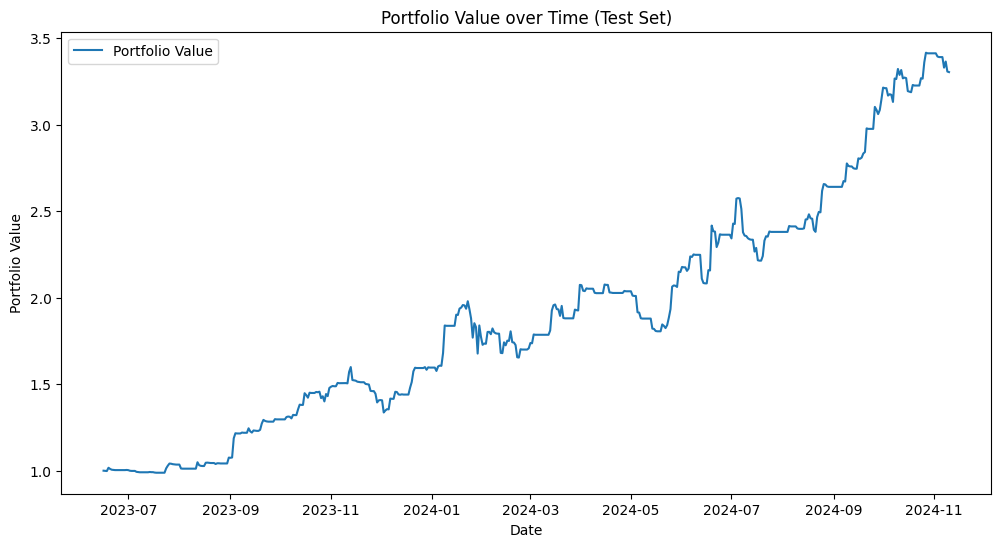

In [59]:
# Portfolio value over time

plt.figure(figsize=(12, 6))
plt.plot(test_df.index[:len(portfolio_values)], portfolio_values, label="Portfolio Value")
plt.title("Portfolio Value over Time (Test Set)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

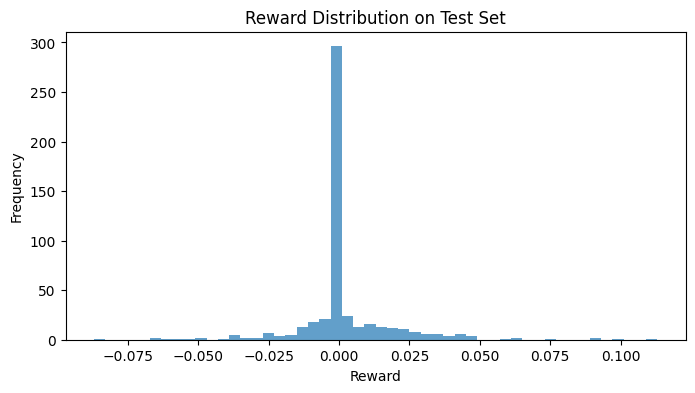

In [60]:
# reward distribution

plt.figure(figsize=(8, 4))
plt.hist(rewards, bins=50, alpha=0.7)
plt.title("Reward Distribution on Test Set")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()


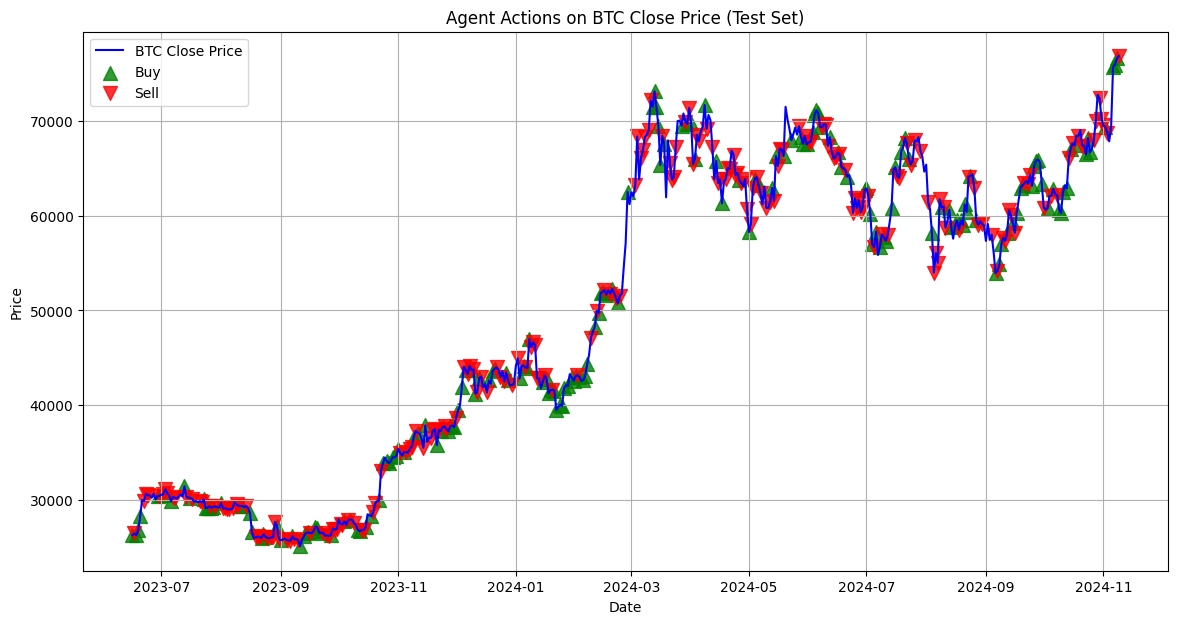

In [61]:
# Agent actions on BTC close price

# Extract closing prices for test period
prices = test_df["Close"].values[:len(actions_taken)]

# Identify buy and sell points
buy_points = np.where(actions_taken == 1)[0]
sell_points = np.where(actions_taken == 2)[0]

plt.figure(figsize=(14, 7))
plt.plot(test_df.index[:len(prices)], prices, label="BTC Close Price", color="blue")

# Plot buy markers
plt.scatter(
    test_df.index[buy_points],
    prices[buy_points],
    marker="^",
    color="green",
    label="Buy",
    alpha=0.8,
    s=100,
)

# Plot sell markers
plt.scatter(
    test_df.index[sell_points],
    prices[sell_points],
    marker="v",
    color="red",
    label="Sell",
    alpha=0.8,
    s=100,
)

plt.title("Agent Actions on BTC Close Price (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


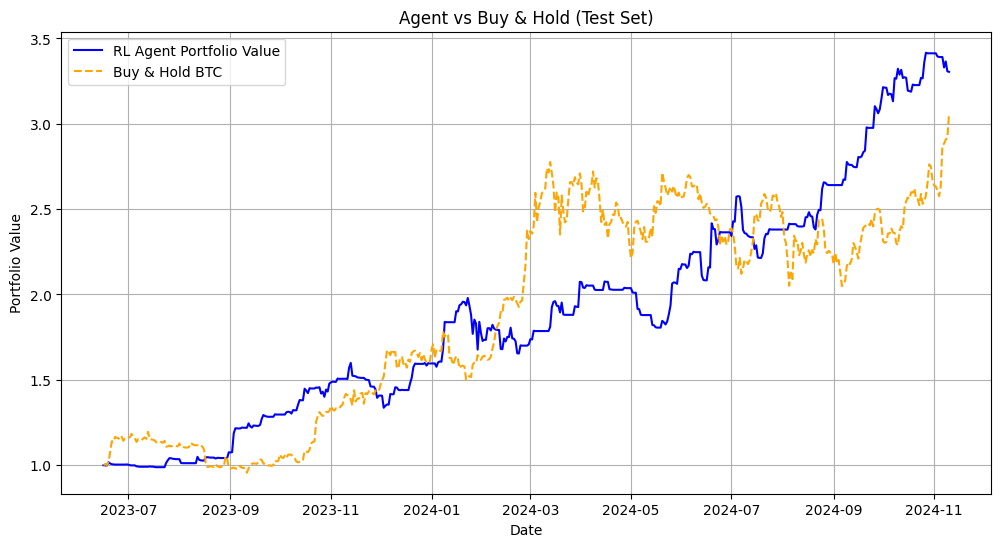

Agent Total Return: 230.42%
Buy & Hold Total Return: 205.67%


In [62]:
# Agent Equity Curve

agent_equity = portfolio_values

# Buy and Hold Equity Curve
initial_cash = agent_equity[0]
# Scale closing prices so that the first value equals initial cash
btc_prices = test_df["Close"].values[:len(agent_equity)]
buy_and_hold_equity = initial_cash * (btc_prices / btc_prices[0])

# Plot Both Curves
plt.figure(figsize=(12, 6))
plt.plot(test_df.index[:len(agent_equity)], agent_equity, label="RL Agent Portfolio Value", color="blue")
plt.plot(test_df.index[:len(agent_equity)], buy_and_hold_equity, label="Buy & Hold BTC", color="orange", linestyle="--")

plt.title("Agent vs Buy & Hold (Test Set)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

# Compute Summary Metrics
agent_return = (agent_equity[-1] / agent_equity[0] - 1) * 100
bh_return = (buy_and_hold_equity[-1] / buy_and_hold_equity[0] - 1) * 100

print(f"Agent Total Return: {agent_return:.2f}%")
print(f"Buy & Hold Total Return: {bh_return:.2f}%")
